In [109]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import mysql.connector
import seaborn as sns
from scipy import stats

In [6]:
%matplotlib inline

### Functions to query SQL from python

In [7]:
#function to run simple SQL query from python
def create_table_from_SQL(user, database, password, query):
    '''
    - A function that returns a pandas dataframe from a SQL query in python
    ---------------
    - user: user for your local SQL connection in string format
    - database: schema name where your database is stored in string format
    - password: password to access your local SQL connection in string format
    - query: SQL query in string format; enclose with double quotes and use single quotes
    to designate VARCHAR values within queries; use schema_name.table_name after FROM statement
    '''
    cnx = mysql.connector.connect(user=user, database=database, password=password)
    cursor = cnx.cursor()
    query = query
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall())
    df.columns = cursor.column_names
    return df

In [10]:
#function to create n number of cursor objects from the SQL dataframe to enable chunking (if necessary)

### Initial Data Analysis

#### *Most frequent defects among NICU admitted patients (2018 only)*

In [11]:
query = "SELECT CA_ANEN, CA_MNSB, CA_CCHD, CA_CDH, CA_OMPH,\
        CA_GAST, CA_LIMB, CA_CLEFT, CA_DOWN, CA_DISOR, CA_HYPO, AB_SEIZ\
        FROM cdc_2018_full\
        WHERE AB_NICU = 'Y'\
        LIMIT 0, 4000000"

In [12]:
nicu_defect = create_table_from_SQL('root','cdc_project','********', query)

In [ ]:
#Cyanotic Congenital Heart Disease, seizures, Gastroschisis show up most frequently among
#NICU admitted patients
nicu_defect.apply(lambda x: sum(x=='Y'), axis=0).sort_values(ascending=False).plot.bar()
plt.title('Total Number of Patients Admitted to the NICU')

#### *Proportion of patients with each defect admitted to NICU vs proportion of non-defect patients admitted - visual results and statistical analysis (2018 only)*

In [8]:
query = "SELECT CA_ANEN, CA_MNSB, CA_CCHD, CA_CDH, CA_OMPH,\
        CA_GAST, CA_LIMB, CA_CLEFT, CA_DOWN, CA_DISOR, CA_HYPO, AB_SEIZ, AB_NICU\
        FROM cdc_2018\
        LIMIT 0, 4000000"

In [9]:
defect_nicu_props = create_table_from_SQL('root','cdc_project','********', query)

In [14]:
overall_prop=len(defect_nicu_props.AB_NICU[defect_nicu_props.AB_NICU=='Y'])/len(defect_nicu_props.AB_NICU)

In [64]:
admits = pd.DataFrame(defect_nicu_props[defect_nicu_props.AB_NICU=='Y'].apply(lambda x: sum(x=='Y'), axis=0))
total = defect_nicu_props.apply(lambda x: sum(x=='Y'), axis=0)
admits = pd.concat([admits,total], axis=1)
admits.columns = ['Admits', 'Total']
admits['props'] = admits['Admits']/admits['Total']
admits = admits.iloc[0:-1,:]
admits = admits.fillna(value=0)

In [78]:
admits.sort_values(by='props', ascending = False, inplace = True)

Text(0.5, 1.0, 'Proportion of Patients with Defect Admitted to the NICU')

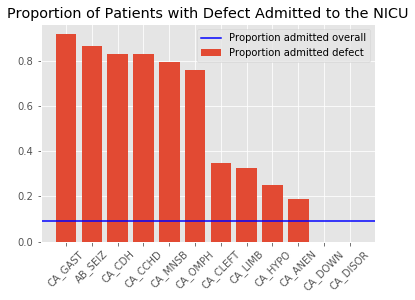

In [118]:
plt.bar(x=admits.index, height = admits.props)
plt.xticks(rotation=45)
plt.axhline(y=overall_prop, color='blue', label='overall NICU admit')
plt.legend(("Proportion admitted overall", "Proportion admitted defect"))
plt.title('Proportion of Patients with Defect Admitted to the NICU')

Text(0.5, 1.0, 'Proportion and Total Admits Two by Two')

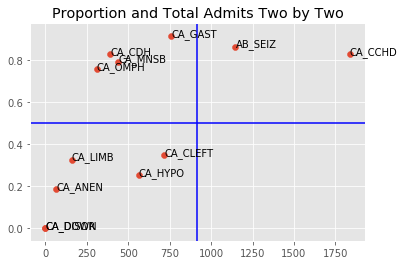

In [117]:
plt.scatter(x=admits.Admits, y=admits.props)
for i, txt in enumerate(admits.index):
    plt.annotate(txt, (admits.Admits[i], admits.props[i]))
plt.axhline(y=0.5, color='blue')
plt.axvline(x=admits['Admits']['CA_CCHD']/2, color='blue')
plt.title('Proportion and Total Admits Two by Two')

### In-Depth Analysis for Prioritized Defects 

In [79]:
#modified version of Bettina's function which creates downsampled dataset for specific defects
#vs overall NICU admissions

def downsample_df (df, variable):

    '''
    Remove undefined information on defect presence admissions (defect == 'U'),
    create a binary target vector, and create a "balanced" dataframe
    with all defect cases and matching numbers of randomly selected non-defect cases.
    --------------------
    df: full dataframe
    variable: variable or defect of interest in string format
    '''

    # remove unknown class from df
    df_no_unknown = df[df[variable].isin(['Y', 'N'])]

    # Create binary target vector, NICU = yes classified as class 0
    df_y_n = pd.DataFrame(np.where((df_no_unknown[variable] == 'Y'), 0, 1))

    # Get indicies of each class' observations
    index_class0 = np.where(df_y_n == 0)[0]
    index_class1 = np.where(df_y_n == 1)[0]

    # Get numbers of observations in class 0
    n_class0 = len(index_class0)

    # Randomly sample the same number of observations from class 1 as in class 0, without replacement
    np.random.seed(0)
    index_class1_downsampled = np.random.choice(index_class1, size=n_class0, replace=False)

    # Create dataframes for NICU and downsampled non-NICU
    df_defect = df_no_unknown.iloc[index_class0]
    df_adj_NONdefect = df_no_unknown.iloc[index_class1_downsampled]

    # Append into 1 dataframe
    df_downsampled = df_defect.append(df_adj_NONdefect)

    return df_downsampled

#### *CA_CCHD as target variable*

In [32]:
# begin dictionary of columns to analyze for CCHD - includes pre-pregnancy and gestational
# characteristics that may be predictive of CCHD based on literature
variables = {'nominal_categorical':['MRACE6', 'FRACE6', 'RF_PDIAB','RF_GDIAB','RF_PHYPE','RF_GHYPE',\
                                  'RF_EHYPE','RF_PPTERM','RF_INFTR','RF_FEDRG','RF_ARTEC','RF_CESAR',\
                                  'IP_GON','IP_SYPH','IP_CHLAM','IP_HEPB','IP_HEPC', 'CA_CCHD'],\
           'ordinal_categorical':[],\
           'continuous':['MAGER', 'FAGECOMB', 'PRIORTERM', 'PRIORLIVE', 'PRIORDEAD',\
                         'PRECARE', 'PREVIS','CIG_0','CIG_1','CIG_2','CIG_3', 'BMI','COMBGEST']}

In [67]:
#pull selected variables from 2018 database in SQL
query = "SELECT MAGER,MRACE6,FAGECOMB,FRACE6,PRIORTERM,PRIORLIVE,PRIORDEAD,PRECARE,PREVIS,\
            CIG_0,CIG_1,CIG_2,CIG_3,BMI,RF_PDIAB,RF_GDIAB,RF_PHYPE,RF_GHYPE,RF_EHYPE,\
            RF_PPTERM,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESAR,IP_GON,IP_SYPH,IP_CHLAM,IP_HEPB,\
            IP_HEPC,COMBGEST,CA_CCHD\
            FROM cdc_project.cdc_2018_full\
            LIMIT 0, 4000000"
cchd18 = create_table_from_SQL('root','cdc_project','********', query)

In [82]:
#downsample database
cchd18 = downsample_df(cchd18, 'CA_CCHD')

In [87]:
#convert continuous variables to float
for x in variables['continuous']:
    cchd18[x]=cchd18[x].astype('float')

In [88]:
#convert nominal categorical variables to category
for x in variables['nominal_categorical']:
    cchd18[x]=cchd18[x].astype('category')

In [129]:
#temporarily impute median into for continuous vars with 99s that represent unknown
for x in ['PRIORTERM','PRIORDEAD','PRIORLIVE','PRECARE', 'PREVIS', 'CIG_0', 'CIG_1',\
         'CIG_2', 'CIG_3', 'FAGECOMB']:
    cchd18[x][cchd18[x]==99] = cchd18[x].median()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
##repeat for 2016,2017 and merge to single dataframe

In [1]:
def continuous_eda(df, var_list, target_var):
    '''
    - A function that analyzes the relationship of a continuous variable to an abnormality target variable
    - Returns overlapping histograms for Y/N target variable groups and a bar graph with means for
    Y/N groups side-by-side. Two-way t-test results are returned underneath the graph.
    ---------------
    - df: the dataframe containing variables of interest
    - var_list: a list of continuous variables as strings
    - target_var: the target abnormality
    '''
    for x in var_list:
        a = df[df[target_var]=='Y'][x]
        b = df[df[target_var]=='N'][x]
        plt.figure()
        plt.subplot(1,2,1)
        plt.hist(a, color='red',alpha=0.3)
        plt.hist(b, color='blue', alpha=0.3)
        plt.figtext(0,0,stats.ttest_ind(a,b))
        plt.title('dist '+x)
        plt.subplot(1,2,2)
        plt.bar('Y', np.mean(a), alpha=0.3)
        plt.bar('N', np.mean(b), alpha=0.3)
        plt.title('mean '+x)

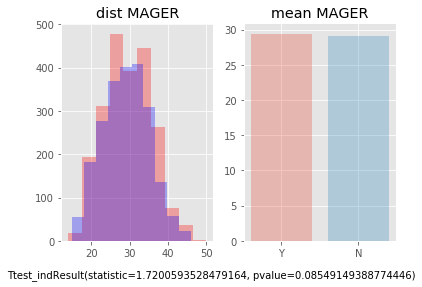

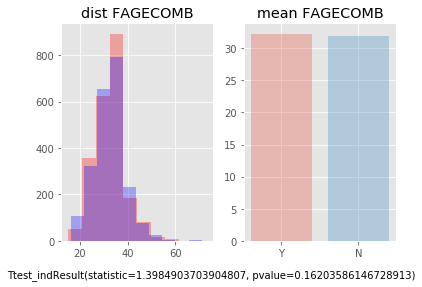

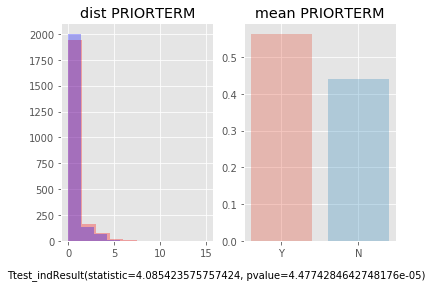

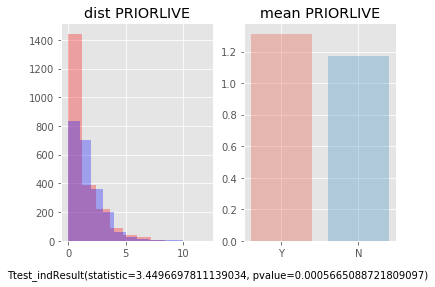

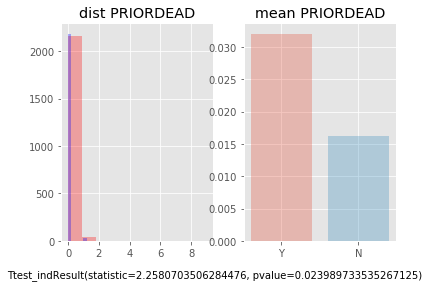

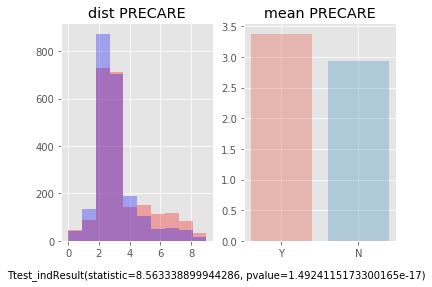

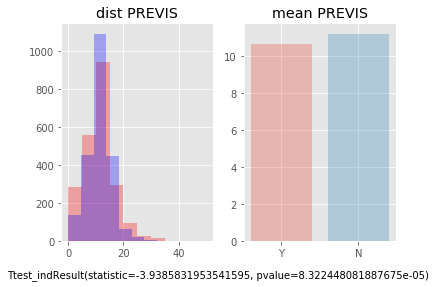

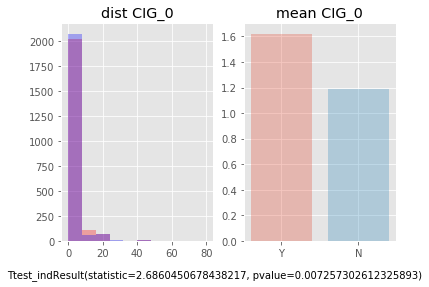

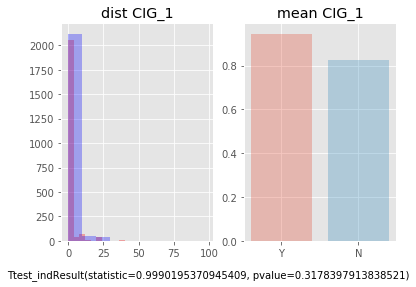

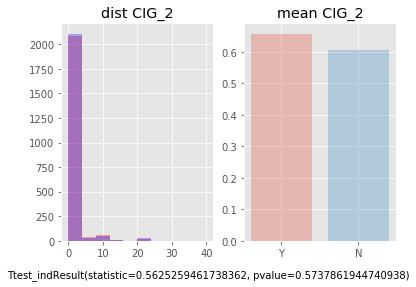

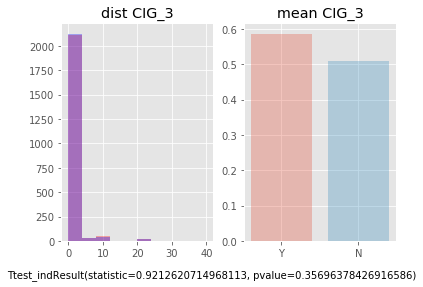

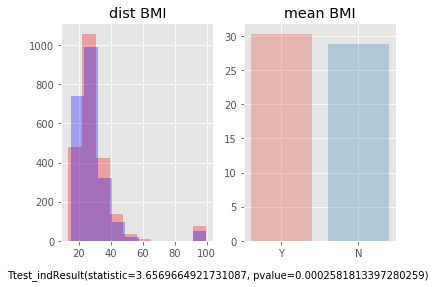

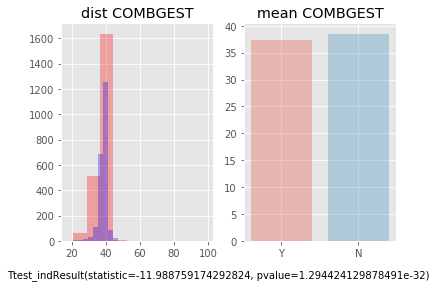

In [151]:
continuous_eda(cchd18, variables['continuous'], 'CA_CCHD')